In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Hyperparameters

IMAGE_SIZE = 32
BATCH_SIZE = 64


# Transform: [0,1] -> [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])


train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    pin_memory=True   
)

print("Total Images:", len(train_dataset))


100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s] 


Total Images: 50000


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [4]:
import matplotlib.pyplot as plt

def show_images(dataset, num_samples=20, cols=4):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        img, _ = dataset[i]     
        img = (img + 1) / 2     
        img = img.permute(1, 2, 0)  

        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()


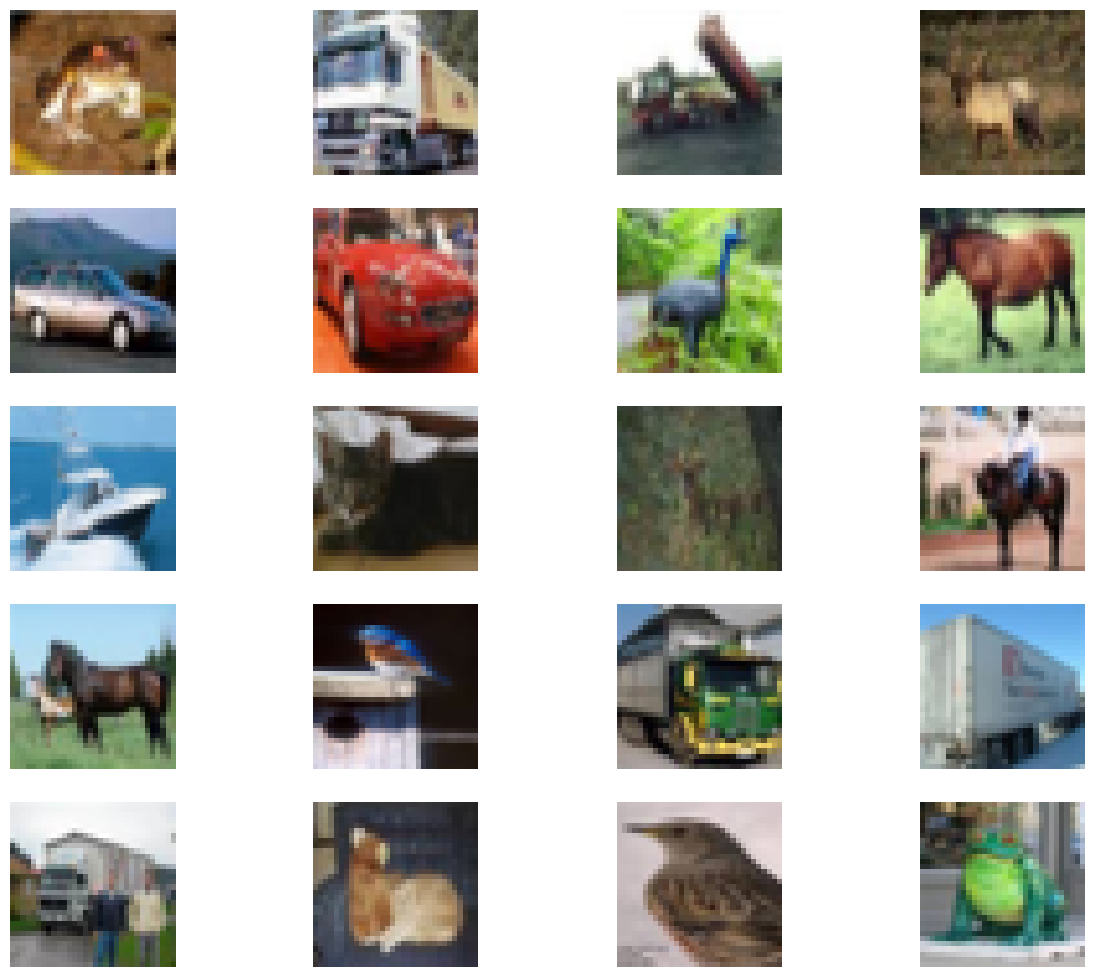

In [5]:
show_images(train_dataset)


In [6]:
import torch
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=1e-4, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    vals: Tensor of shape [T]
    t: Tensor of shape [B]
    x_shape: (B, C, H, W)
    """
    batch_size = t.shape[0]
    out = vals.gather(0, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t):
    """
    x_0: clean images (B, C, H, W)
    t: timesteps (B,)
    """
    noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t = get_index_from_list(
        sqrt_alphas_cumprod, t, x_0.shape
    )
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    x_t = (
        sqrt_alphas_cumprod_t * x_0 +
        sqrt_one_minus_alphas_cumprod_t * noise
    )

    return x_t, noise

T = 300  # number of diffusion steps

betas = linear_beta_schedule(T).to(device)
alphas = 1.0 - betas

alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)


In [7]:
x, _ = next(iter(train_loader))
x = x.to(device)

t = torch.randint(0, T, (x.size(0),), device=device)
x_t, noise = forward_diffusion_sample(x, t)

print(x_t.shape, x_t.device)


torch.Size([64, 3, 32, 32]) cuda:0


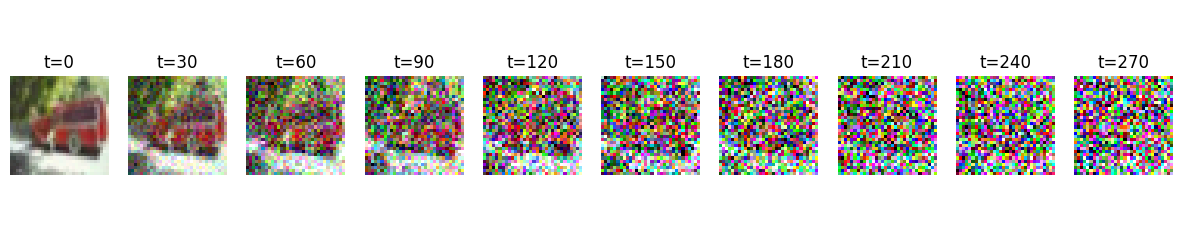

In [9]:
import matplotlib.pyplot as plt

images, _ = next(iter(train_loader))
images = images.to(device)

num_images = 10
stepsize = T // num_images

plt.figure(figsize=(15, 3))
plt.axis("off")

for i, idx in enumerate(range(0, T, stepsize)):
    t = torch.full(
        (images.size(0),),
        idx,
        device=device,
        dtype=torch.long
    )

    x_t, _ = forward_diffusion_sample(images, t)

    img = x_t[0]
    img = (img + 1) / 2              # unnormalize
    img = img.permute(1, 2, 0).cpu() # CHW → HWC

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.title(f"t={idx}")
    plt.axis("off")

plt.show()


In [10]:
import torch
from torch import nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb



class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        if up:
            self.conv1 = nn.Conv2d(in_ch * 2, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))

        # time embedding
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[:, :, None, None]  # (B, C, 1, 1)

        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))

        return self.transform(h)


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()

        image_channels = 3
        down_channels = (64, 128, 256, 512)
        up_channels = (512, 256, 128, 64)
        time_emb_dim = 32

        # time embedding MLP
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i + 1], time_emb_dim)
            for i in range(len(down_channels) - 1)
        ])

        
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
            for i in range(len(up_channels) - 1)
        ])

        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)

        x = self.conv0(x)

        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        for up in self.ups:
            res = residuals.pop()
            x = torch.cat((x, res), dim=1)
            x = up(x, t)

        return self.output(x)


model = SimpleUnet().to(device)
print("Num params:", sum(p.numel() for p in model.parameters()))


Num params: 15453667


In [11]:
import torch.nn.functional as F

def get_loss(model, x_0, t):
    """
    model: UNet
    x_0: clean images (B, C, H, W)
    t: timesteps (B,)
    """
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)

    return F.mse_loss(noise_pred, noise)


In [12]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(
        sqrt_recip_alphas, t, x.shape
    )

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    posterior_variance_t = get_index_from_list(
        posterior_variance, t, x.shape
    )

    if torch.all(t == 0):
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


In [13]:
@torch.no_grad()
def sample_plot_image():
    img_size = 32  
    img = torch.randn((1, 3, img_size, img_size), device=device)

    plt.figure(figsize=(15, 3))
    plt.axis("off")

    num_images = 10
    stepsize = T // num_images

    for i in reversed(range(T)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)

        if i % stepsize == 0:
            idx = i // stepsize
            plt.subplot(1, num_images, idx + 1)

            
            show = (img[0] + 1) / 2
            show = show.permute(1, 2, 0).cpu()

            plt.imshow(show)
            plt.axis("off")

    plt.show()


In [ ]:
from torch.optim import Adam
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 100

for epoch in range(epochs):
    pbar = tqdm(train_loader)

    for step, (images, _) in enumerate(pbar):
        optimizer.zero_grad()

        images = images.to(device)

        t = torch.randint(
            0, T,
            (images.size(0),),
            device=device
        ).long()

        loss = get_loss(model, images, t)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    if epoch % 10 == 0:
        print(f"\nSampling at epoch {epoch}")
        sample_plot_image()


Epoch 0 | Loss: 0.0851: 100%|██████████| 781/781 [01:11<00:00, 10.98it/s]



Sampling at epoch 0
